In [1]:
from typing import List
import ibis
from ibis import config as cf
from ibis.sql.postgres import existing_udf

import pandas as pd

with cf.config_prefix('sql'):
    k = 'default_limit'
    cf.set_option(k, None)

In [2]:
con = ibis.postgres.connect(
    host='localhost',
    port=25432,
    user='dengueadmin',
    password='aldengue',
    database='dengue'
)
con.list_tables()

['auth_group',
 'auth_group_permissions',
 'auth_permission',
 'auth_user',
 'auth_user_groups',
 'auth_user_user_permissions',
 'chunked_upload_chunkedupload',
 'dbf_dbf',
 'dbf_dbfchunkedupload',
 'django_admin_log',
 'django_content_type',
 'django_migrations',
 'django_session',
 'geography_columns',
 'geometry_columns',
 'raster_columns',
 'raster_overviews',
 'spatial_ref_sys',
 'teste',
 'uf_total_chik_view',
 'uf_total_view',
 'uf_total_zika_view']

In [3]:
DISEASES_SHORT = ['dengue', 'chik', 'zika']

In [4]:
schema_dengue_global = con.schema('Dengue_global')
schema_dengue_global.list_tables()

['CID10', 'Municipio', 'estado', 'parameters', 'regional_saude']

In [5]:
schema_city = con.schema('Municipio')
schema_city.list_tables()

['Bairro',
 'Clima_Satelite',
 'Clima_cemaden',
 'Clima_wu',
 'Estacao_cemaden',
 'Estacao_wu',
 'Historico_alerta',
 'Historico_alerta_chik',
 'Historico_alerta_zika',
 'Localidade',
 'Notificacao',
 'Ovitrampa',
 'Tweet',
 'alerta_mrj',
 'alerta_mrj_chik',
 'alerta_mrj_zika',
 'historico_casos']

In [6]:
t_estado = schema_dengue_global.table('estado')
t_estado[t_estado.nome, t_estado.uf, t_estado.geocodigo].head().execute()

,nome,uf,geocodigo
0,MINAS GERAIS,mg,31
1,PERNAMBUCO,pe,26
2,ALAGOAS,al,27
3,MARANHÃO,ma,21
4,RONDÔNIA,ro,11


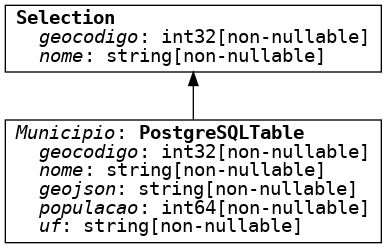

In [7]:
# preare cities dictionary
t_cities = schema_dengue_global.table('Municipio')

uf_filter_ceara = t_cities.uf == 'Ceará'
keys = [t_cities.geocodigo, t_cities.nome]

expr_cities = t_cities[uf_filter_ceara][keys]

df_cities = expr_cities.execute().set_index('geocodigo')
cities = df_cities.to_dict()['nome']

expr_cities

In [8]:
str(cities)[:50] + '...'

"{2305233: 'Horizonte', 2305266: 'Ibaretama', 23053..."

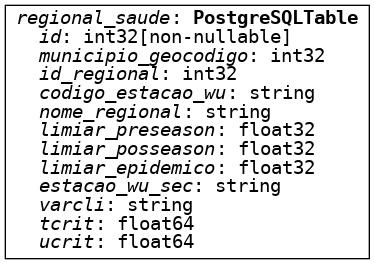

In [9]:
# prepare station_id
t_rsaude = schema_dengue_global.table('regional_saude')
t_rsaude

In [10]:
rsaude_keys = [
    t_rsaude.municipio_geocodigo,
    t_rsaude.codigo_estacao_wu,
    t_rsaude.varcli,
    t_cities.uf,
    t_cities.nome
]

expr_rsaude = t_rsaude.join(
    t_cities, 
    (t_rsaude.municipio_geocodigo == t_cities.geocodigo) 
    & (t_cities.uf == 'Ceará')
)
print(expr_rsaude[rsaude_keys].head().execute())

   municipio_geocodigo codigo_estacao_wu    varcli     uf         nome
0              2305233              SBFZ  umid_max  Ceará    Horizonte
1              2305266              SBTE  umid_max  Ceará    Ibaretama
2              2305308              SBFZ  umid_max  Ceará     Ibiapina
3              2305332              SBTE  umid_max  Ceará  Ibicuitinga
4              2305357              SBFZ  umid_max  Ceará       Icapuí


### Part 1

In [11]:
var_climate = 'umid_max'
year_week = 202002
station_id = 'SBFZ'

general_param = {
    'year_week_start': year_week - 200,
    'year_week_end': year_week,
    'geocodes': ','.join(map(lambda v: repr(str(v)), cities)),
    'geocodes_list': [v for v in cities],
    'var_climate': var_climate,
    'station_id': station_id,
}

disease = 'dengue'

_param = dict(general_param)
_param['disease'] = disease

table_suffix = ''
if disease != 'dengue':
    table_suffix = '_{}'.format(disease)

_param['table_suffix'] = table_suffix

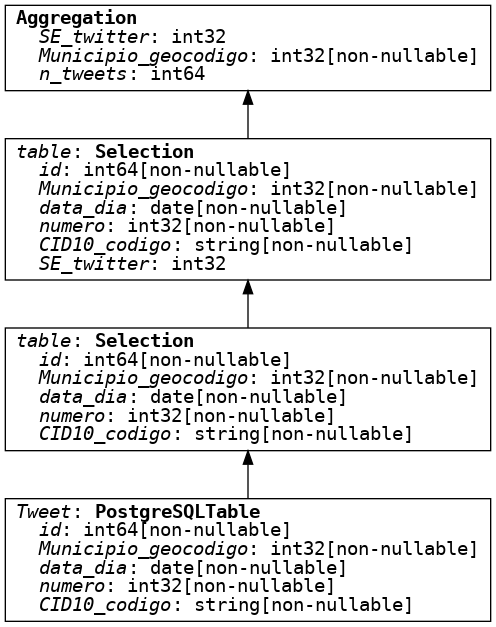

In [12]:
epi_week_fn = existing_udf(
    'epi_week',
    input_types=['date'],
    output_type='int32'
)

t_tweet = schema_city.table('Tweet')
filter_tweet_cities = t_tweet.Municipio_geocodigo.isin(
    general_param['geocodes_list']
)
t_tweet = t_tweet[filter_tweet_cities]
t_tweet = t_tweet.mutate(SE_twitter=epi_week_fn(t_tweet.data_dia))

expr_tweet = t_tweet.groupby([
    t_tweet.SE_twitter,
    t_tweet.Municipio_geocodigo,
    
]).aggregate(
    n_tweets=t_tweet.numero.sum()
)

filter_tweet = (
    t_tweet.SE_twitter.between(
        general_param['year_week_start'], 
        general_param['year_week_end']
    )
)

# ORDER BY "SE_twitter" DESC
expr_tweet = expr_tweet[filter_tweet].sort_by(('SE_twitter', False))
expr_tweet

In [13]:
def get_epi_week_expr():
    return existing_udf(
        'epi_week',
        input_types=['date'],
        output_type='int64'
    )

def get_epiweek2date_expr():
    return existing_udf(
        'epiweek2date',
        input_types=['int64'],
        output_type='date'
    )


def get_hist_disease_expr(
    disease: str,
    geocodes: List[int],
    year_week_start: int,
    year_week_end: int,
):
    table_suffix = ''
    if disease != 'dengue':
        table_suffix = '_{}'.format(disease)
    
    schema_city = con.schema('Municipio')
    t_hist = schema_city.table('Historico_alerta{}'.format(table_suffix))

    case_level = (
        ibis.case()
        .when((t_hist.nivel.cast('string') == '1'), 'verde')
        .when((t_hist.nivel.cast('string') == '2'), 'amarelo')
        .when((t_hist.nivel.cast('string') == '3'), 'laranja')
        .when((t_hist.nivel.cast('string') == '4'), 'vermelho')
        .else_('-')
        .end()
    ).name(f'nivel_{disease}')

    hist_keys = [
        t_hist.SE.name(f'SE_{disease}'),
        t_hist.casos.name(f'casos_{disease}'),
        t_hist.p_rt1.name(f'p_rt1_{disease}'),
        t_hist.casos_est.name(f'casos_est_{disease}'),
        t_hist.p_inc100k.name(f'p_inc100k_{disease}'),
        t_hist.nivel.name(f'level_code_{disease}'),
        case_level,
        t_hist.municipio_geocodigo.name(f'geocode_{disease}')
    ]

    hist_filter = (
        (t_hist['SE'].between(year_week_start, year_week_end))
        & (t_hist['municipio_geocodigo'].isin(geocodes))
    )

    return t_hist[hist_filter][hist_keys].sort_by(f'SE_{disease}')


def get_twitter_expr(
    geocodes_list: List[int], 
    year_week_start: int,
    year_week_end: int
):
    epi_week_fn = get_epi_week_expr()
    
    t_tweet = schema_city.table('Tweet')
    filter_tweet_cities = t_tweet.Municipio_geocodigo.isin(
        geocodes_list
    )
    t_tweet = t_tweet[filter_tweet_cities]
    t_tweet = t_tweet.mutate(SE_twitter=epi_week_fn(t_tweet.data_dia))

    expr_tweet = t_tweet.groupby([
        t_tweet.SE_twitter,
        t_tweet.Municipio_geocodigo,

    ]).aggregate(
        n_tweets=t_tweet.numero.sum()
    )

    filter_tweet = (
        t_tweet.SE_twitter.between(
            general_param['year_week_start'], 
            general_param['year_week_end']
        )
    )

    return expr_tweet[filter_tweet].sort_by(('SE_twitter', False))


def get_climate_wu_expr(var_climate: str, station_id: str):
    epi_week_fn = get_epi_week_expr()
    
    schema_city = con.schema('Municipio')
    
    t_climate_wu = schema_city.table('Clima_wu')
    
    expr_filter = t_climate_wu.Estacao_wu_estacao_id == station_id
    t_climate_wu = t_climate_wu[expr_filter]
    t_climate_wu = t_climate_wu.mutate(
        epiweek_climate=epi_week_fn(t_climate_wu.data_dia)
    )
    
    expr_climate_wu = t_climate_wu.groupby([
        t_climate_wu.epiweek_climate
    ]).aggregate(
        **{var_climate: t_climate_wu[var_climate].mean().name(var_climate)}
    )
    
    return expr_climate_wu.sort_by(t_climate_wu.epiweek_climate)
    
    
hist_disease_expr = {}
hist_prev = None
joined_expr = None
previous_disease = None

for disease in DISEASES_SHORT:
    hist_expr = get_hist_disease_expr(
        disease, 
        general_param['geocodes_list'],
        general_param['year_week_start'],
        general_param['year_week_end'],
    )
    hist_disease_expr[disease] = hist_expr
    
    if joined_expr is None:
        joined_expr = hist_expr
    else:
        # todo: review join approach
        hist_prev = hist_disease_expr[previous_disease]
        joined_cond = (
            (hist_prev[f'SE_{previous_disease}'] == hist_expr[f'SE_{disease}'])
            & (hist_prev[f'geocode_{previous_disease}'] == hist_expr[f'geocode_{disease}'])
        )
        joined_expr = joined_expr.left_join(
            hist_expr,
            joined_cond
        )
    previous_disease = disease

# twitter data
expr_tweet = get_twitter_expr(
    general_param['geocodes_list'],
    general_param['year_week_start'],
    general_param['year_week_end'],
)
expr_dengue = hist_disease_expr['dengue']

joined_expr = joined_expr.left_join(
    expr_tweet, 
    (
        (
            expr_tweet.Municipio_geocodigo == expr_dengue.geocode_dengue
        ) & (
            expr_tweet.SE_twitter == expr_dengue.SE_dengue
        )
    )
)

climate_wu_expr = get_climate_wu_expr(
    general_param['var_climate'], 
    general_param['station_id']
)

joined_expr = joined_expr.left_join(
    climate_wu_expr, 
    hist_disease_expr['dengue'].SE_dengue == climate_wu_expr.epiweek_climate
).materialize()

epiweek2date_fn = get_epiweek2date_expr()

k = ['casos', 'p_inc100k', 'casos_est', 'p_rt1', 'nivel', 'level_code']
proj = [joined_expr['{}_{}'.format(v, d)] for v in k for d in DISEASES_SHORT]
proj.extend([
    joined_expr[var_climate],
    joined_expr['n_tweets'],
    joined_expr['geocode_dengue'].name('geocode'),
    joined_expr['SE_dengue'].name('SE'),
    epiweek2date_fn(joined_expr.SE_dengue).name('init_date_week'),
])

%time df_ibis = joined_expr[proj].execute()

CPU times: user 775 ms, sys: 31.9 ms, total: 807 ms
Wall time: 9.13 s


In [14]:
def sql_read_disease_data(
    cities: dict, station_id: str, year_week: int, var_climate: str
) -> pd.DataFrame:
        """
        :param cities:
        :param station_id:
        :param year_week:
        :param var_climate:
        :return:
        """
        
        DISEASES = ['dengue', 'chik', 'zika']

        k = ['casos', 'p_inc100k', 'casos_est', 'p_rt1', 'nivel', 'level_code']

        k = ['{}_{}'.format(v, d) for v in k for d in DISEASES]

        k.append(var_climate)
        k.append('n_tweets')
        k.append('geocode_dengue AS geocode')
        k.append('"SE_dengue" AS "SE"')
        k.append('epiweek2date("SE_dengue") AS init_date_week')

        general_param = {
            'year_week_start': year_week - 200,
            'year_week_end': year_week,
            'geocodes': ','.join(map(lambda v: "'{}'".format(v), cities)),
            'var_climate': var_climate,
            'station_id': station_id,
        }

        sql = ''
        previous_disease = ''
        for disease in DISEASES:
            _param = dict(general_param)
            _param['disease'] = disease

            table_suffix = ''
            if disease != 'dengue':
                table_suffix = '_{}'.format(disease)

            _param['table_suffix'] = table_suffix

            sql_ = (
                '''
            (SELECT
               hist."SE" AS "SE_%(disease)s",
               hist.casos AS casos_%(disease)s,
               hist.p_rt1 AS p_rt1_%(disease)s,
               hist.casos_est AS casos_est_%(disease)s,
               hist.p_inc100k AS p_inc100k_%(disease)s,
               hist.nivel AS level_code_%(disease)s,
               (CASE
                  WHEN hist.nivel=1 THEN 'verde'
                  WHEN hist.nivel=2 THEN 'amarelo'
                  WHEN hist.nivel=3 THEN 'laranja'
                  WHEN hist.nivel=4 THEN 'vermelho'
                  ELSE '-'
                END) AS nivel_%(disease)s,
                hist.municipio_geocodigo AS geocode_%(disease)s
            FROM
             "Municipio"."Historico_alerta%(table_suffix)s" AS hist
            WHERE
             hist."SE" BETWEEN %(year_week_start)s AND %(year_week_end)s
             AND hist.municipio_geocodigo IN (%(geocodes)s)
            ORDER BY "SE_%(disease)s" DESC
            ) AS %(disease)s
            '''
                % _param
            )

            if not sql:
                sql = sql_
            else:
                sql += '''
                    LEFT JOIN {0}
                    ON (
                      {1}."SE_{1}" = {2}."SE_{2}"
                      AND {1}.geocode_{1} = {2}.geocode_{2}
                    )
                '''.format(
                    sql_, previous_disease, disease
                )
            previous_disease = disease

        tweet_join = (
            '''
        LEFT JOIN (
           SELECT
             epi_week(data_dia) AS "SE_twitter",
             SUM(numero) as n_tweets,
             "Municipio_geocodigo"
           FROM "Municipio"."Tweet"
           WHERE
             "Municipio_geocodigo" IN (%(geocodes)s)
             AND epi_week(data_dia)
               BETWEEN %(year_week_start)s AND %(year_week_end)s
           GROUP BY "SE_twitter", "Municipio_geocodigo"
           ORDER BY "SE_twitter" DESC
        ) AS tweets
           ON (
             "Municipio_geocodigo"=dengue."geocode_dengue"
             AND tweets."SE_twitter"=dengue."SE_dengue"
           )
        '''
            % general_param
        )

        climate_join = (
            '''
        LEFT JOIN (
          SELECT
             epi_week(data_dia) AS epiweek_climate,
             AVG(%(var_climate)s) AS %(var_climate)s
          FROM "Municipio"."Clima_wu"
          WHERE "Estacao_wu_estacao_id" = '%(station_id)s'
          GROUP BY epiweek_climate
          ORDER BY epiweek_climate
        ) AS climate_wu
           ON (dengue."SE_dengue"=climate_wu.epiweek_climate)
        '''
            % general_param
        )

        sql += climate_join + tweet_join

        sql = ' SELECT {} FROM ({}) AS data'.format(','.join(k), sql)
        df = pd.read_sql(sql, index_col='SE', con=con.con)
        return df

In [15]:
%time df_sql = sql_read_disease_data(cities, station_id, year_week, var_climate)

CPU times: user 235 ms, sys: 12.3 ms, total: 248 ms
Wall time: 11.5 s


In [16]:
df_sql.init_date_week.dtype

dtype('O')

In [17]:
_df_sql = df_sql.copy()
_df_sql = _df_sql.astype({'init_date_week': 'datetime64[ns]'})
_df_sql.init_date_week.dtype

dtype('<M8[ns]')

In [18]:
# set index
_df_ibis = df_ibis.set_index('SE', drop=True)
# use the same data type for both dataframes
_df_ibis = _df_ibis.astype({
    col_name: col_type for col_name, col_type in df_sql.dtypes.items()
})
# reformat datatype
_df_ibis.init_date_week = _df_ibis.init_date_week.apply(lambda v: v.to_pydatetime())
_df_sql.init_date_week = _df_sql.init_date_week.apply(lambda v: v.to_pydatetime())
# test
pd.testing.assert_frame_equal(_df_ibis, _df_sql)

## Part 2

In [19]:
# original
def episem(x, sep='W', out='YW'):

    """
    Return Brazilian corresponding epidemiological week from x.

    :param x: Input date. Can be a string in the format %Y-%m-%d or
      datetime.datetime
    :param sep: Year and week separator.
    :param out: Output format. 'YW' returns sep.join(epiyear,epiweek).
     'Y' returns epiyear only. 'W' returns epiweek only.
    :return: str
    """

    def out_format(year, week, out, sep='W'):
        if out == 'YW':
            return '%s%s%02d' % (year, sep, week)
        if out == 'Y':
            return '%s' % (year)
        if out == 'W':
            return '%02d' % week

    if type(x) != datetime.datetime:
        if str(x) == '' or x is None or (type(x) != str and np.isnan(x)):
            return None
        x = datetime.datetime.strptime(x, '%Y-%m-%d')

    epiyear = x.year
    epiend = lastepiday(epiyear)

    if x > epiend:
        epiyear += 1
        return out_format(epiyear, 1, out, sep)

    epistart = firstepiday(epiyear)

    # If current date is before its year first epiweek,
    # then our base year is the previous one
    if x < epistart:
        epiyear -= 1
        epistart = firstepiday(epiyear)

    epiweek = int(((x - epistart) / 7).days) + 1

    return out_format(epiyear, epiweek, out, sep)

In [20]:
def format_df_original(df):
    if not df.empty:
        dfs = []

        # merge with a range date dataframe to keep empty week on the data
        ts_date = pd.date_range(
            df['init_date_week'].min(),
            df['init_date_week'].max(),
            freq='7D',
        )
        df_date = pd.DataFrame({'init_date_week': ts_date})

        for geocode in df.geocode.unique():
            df_ = df[df.geocode == geocode].sort_values('init_date_week')

            df_date_ = df_date.set_index(
                df_.init_date_week.map(
                    lambda x: int(episem(str(x)[:10], sep=''))
                ),
                drop=True,
            )

            df_.index.name = None
            df_date_.index.name = None

            df_['init_date_week'] = pd.to_datetime(
                df_['init_date_week'], errors='coerce'
            )

            dfs.append(
                pd.merge(
                    df_,
                    df_date_,
                    how='outer',
                    on='init_date_week',
                    left_index=True,
                    right_index=True,
                )
            )

        df = pd.concat(dfs)

    df.sort_index(ascending=True, inplace=True)

    for d in DISEASES_SHORT:
        k = 'p_rt1_{}'.format(d)
        df[k] = (df[k] * 100).fillna(0)
        k = 'casos_est_{}'.format(d)
        df[k] = df[k].fillna(0).round(0)
        k = 'p_inc100k_{}'.format(d)
        df[k] = df[k].fillna(0).round(0)

        df.rename(
            columns={
                'p_inc100k_{}'.format(d): 'incidência {}'.format(d),
                'casos_{}'.format(d): 'casos notif. {}'.format(d),
                'casos_est_{}'.format(d): 'casos est. {}'.format(d),
                'p_rt1_{}'.format(d): 'pr(incid. subir) {}'.format(d),
            },
            inplace=True,
        )

    df.n_tweets = df.n_tweets.fillna(0).round(0)

    return df.rename(
        columns={
            'umid_max': 'umid.max',
            'temp_min': 'temp.min',
            'n_tweets': 'tweets',
        }
    )


In [ ]:
def format_df_new(df):
    if not df.empty:
        dfs = []

        # merge with a range date dataframe to keep empty week on the data
        ts_date = pd.date_range(
            df['init_date_week'].min(),
            df['init_date_week'].max(),
            freq='7D',
        )
        df_date = pd.DataFrame({'init_date_week': ts_date})

        for geocode in df.geocode.unique():
            df_ = df[df.geocode == geocode].sort_values('init_date_week')

            df_date_ = df_date.set_index(
                df_.init_date_week.map(
                    lambda x: int(episem(str(x)[:10], sep=''))
                ),
                drop=True,
            )

            df_.index.name = None
            df_date_.index.name = None

            df_['init_date_week'] = pd.to_datetime(
                df_['init_date_week'], errors='coerce'
            )

            dfs.append(
                pd.merge(
                    df_,
                    df_date_,
                    how='outer',
                    on='init_date_week',
                    left_index=True,
                    right_index=True,
                )
            )

        df = pd.concat(dfs)

    df.sort_index(ascending=True, inplace=True)

    for d in DISEASES_SHORT:
        k = 'p_rt1_{}'.format(d)
        df[k] = (df[k] * 100).fillna(0)
        k = 'casos_est_{}'.format(d)
        df[k] = df[k].fillna(0).round(0)
        k = 'p_inc100k_{}'.format(d)
        df[k] = df[k].fillna(0).round(0)

        df.rename(
            columns={
                'p_inc100k_{}'.format(d): 'incidência {}'.format(d),
                'casos_{}'.format(d): 'casos notif. {}'.format(d),
                'casos_est_{}'.format(d): 'casos est. {}'.format(d),
                'p_rt1_{}'.format(d): 'pr(incid. subir) {}'.format(d),
            },
            inplace=True,
        )

    df.n_tweets = df.n_tweets.fillna(0).round(0)

    return df.rename(
        columns={
            'umid_max': 'umid.max',
            'temp_min': 'temp.min',
            'n_tweets': 'tweets',
        }
    )


In [21]:
%time prepare_df_original(pd.DataFrame())

KeyError: 'p_rt1_dengue'